In [1]:
# RNN on sine wave, using bp on weight matrix, enforce Dale's law (clipping)
# Unstable in the later period of training
import numpy as np
import sys
sys.path.append("../../model")
from rnn_sin2 import RNN
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import seaborn as sns
from tqdm.notebook import tqdm

## Loading Trained Weights

In [2]:
num_nodes = 16
filedir = "../weights/"
filename = "SIN2_wtpt_" + str(num_nodes) + "_nodes.json"
filepath = filedir + filename
with open(filepath) as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'init_weight', 'init_activations'])

In [4]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
init_activations = np.array(weight_history['init_activations'])
losses = np.array(weight_history['losses'])

# Dale's Law
num_nodes = 16
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = [1]*excite_num + [-1]*(num_nodes-excite_num)
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

In [5]:
np.max(weight_matrix)

3.1400814056396484

Text(0.5, 1.0, 'Weight matrix')

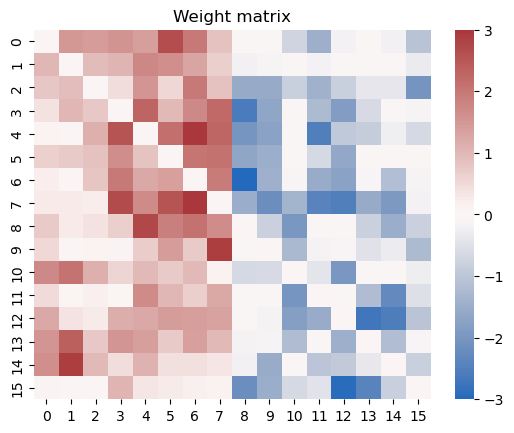

In [6]:
sns.heatmap(weight_matrix, vmax=3, vmin=-3, cmap='vlag')
plt.title('Weight matrix')

In [7]:
excite_weights = weight_matrix * (weight_type > 0)
np.sum(excite_weights)

134.99988732440397

In [8]:
inhib_weights = weight_matrix * (weight_type < 0)
np.sum(inhib_weights)

-109.67225901401434

## Defining Network

In [9]:
time_constant = 100 #ms
timestep = 10 #ms
ndata = 800
time = ndata * timestep #ms
num_inputs = 1
num_nodes = 16

100%|██████████| 800/800 [00:00<00:00, 14418.80it/s]


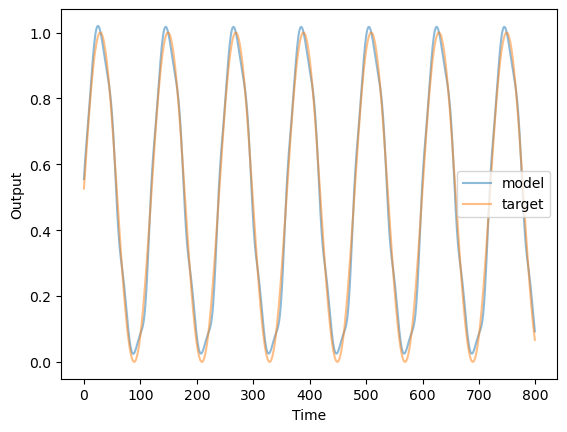

In [10]:
time_points = np.arange(ndata).reshape(-1, 1)
inputs = (1 + np.sin(time_points/60*np.pi))/2
targets = (1 + np.sin((time_points+1)/60*np.pi))/2
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)
outputs, activations = network.simulate(time, torch.tensor(inputs).float())

fig, ax = plt.subplots()
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='model')
plt.plot(time_points, targets, alpha=0.5, label='target')
# plt.ylim([0,1])
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
# plt.savefig("fig/0122_SIN2_bphebbpt_output.png")

Text(50.722222222222214, 0.5, 'Node')

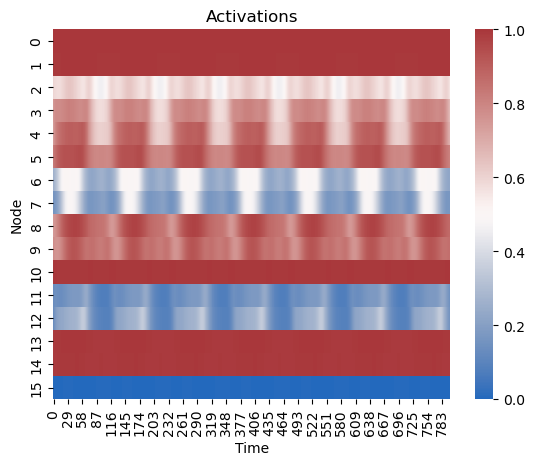

In [11]:
activations_t = activations.detach().numpy().T
sns.heatmap(activations_t, cmap='vlag', vmax=1, vmin=0)
plt.title('Activations')
plt.xlabel('Time')
plt.ylabel('Node')
# plt.savefig('fig/0221_SIN2_bphcppt_activations.png')

(0.0, 0.1)

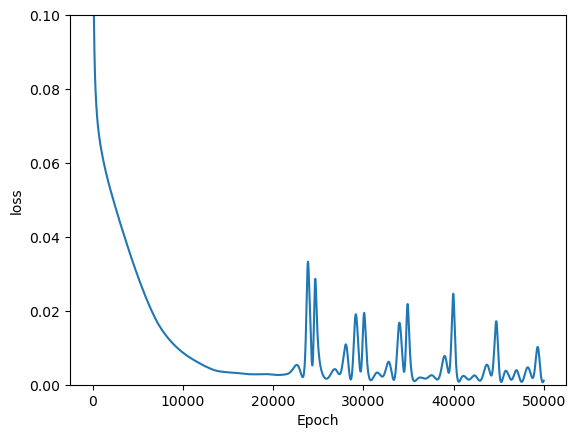

In [12]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.ylim([0,0.1])
# plt.savefig("fig/sin_oja_loss.png")